<a href="https://colab.research.google.com/github/takchiks/Makerere/blob/main/Copy_of_Copy_of_Local_Passion_Fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Passion Fruits, Object detection and localization model

In [ ]:
import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read the csv files

### Train

In [ ]:
!cp 'drive/My Drive/Passion_Fruit_Dataset/Train_Images.zip' Train_Images.zip
!cp 'drive/My Drive/Passion_Fruit_Dataset/Test_Images.zip' Test_Images.zip


In [ ]:
!unzip -q Train_Images.zip 
!unzip -q Test_Images.zip 


replace __MACOSX/._Train_Images? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace __MACOSX/._Test_Images? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Passion_Fruit_Dataset/Train.csv')
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
train_df.shape

(3906, 6)

In [ ]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(3001, 6)


We have 3906 bounding boxes, from a collection of 3001 images. Some images have 1 bounding box, while others have more than 1 bounding box.

### Test

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Passion_Fruit_Dataset/Test.csv")
test_df.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [ ]:
test_df.shape

(931, 1)

In [ ]:
# train_df['xmax'] = train_df['xmin']+train_df1['width']
# train_df['ymax'] = train_df['ymin']+train_df['height']

- Encode the classes from str to int One Hot Encoding

In [ ]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [ ]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,3,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,233.5,182.0


In [ ]:
xmax = train_df['xmin']+train_df['width']
# train_df['ymax'] = train_df['ymin']+train_df['height']
train_df.insert(4, column='xmax', value=xmax)

In [ ]:
train_df.head()

,Image_ID,class,xmin,ymin,xmax,width,height
0,ID_007FAIEI,3,87.0,87.5,315.0,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,342.5,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,404.5,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,379.5,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,313.0,233.5,182.0


In [ ]:
ymax = train_df['ymin']+train_df['height']
# train_df['ymax'] = train_df['ymin']+train_df['height']
train_df.insert(5, column='ymax', value=ymax)

In [ ]:
train_df

,Image_ID,class,xmin,ymin,xmax,ymax,width,height
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5,233.5,182.0
...,...,...,...,...,...,...,...,...
3901,ID_ZZAB1FH1,2,96.0,175.5,385.5,397.5,289.5,222.0
3902,ID_ZZAB1FH1,2,330.0,241.0,512.0,421.5,182.0,180.5
3903,ID_ZZJZ2CV6,2,358.0,234.0,492.5,341.0,134.5,107.0
3904,ID_ZZJZ2CV6,2,98.5,135.0,374.0,348.5,275.5,213.5


In [ ]:
# train_df['xmin'] = train_df['xmin'].astype(np.float)
# train_df['ymin'] = train_df['ymin'].astype(np.float)
# train_df['width'] = train_df['width'].astype(np.float)
# train_df['height'] = train_df['height'].astype(np.float)
# train_df['xmax'] = train_df['xmax'].astype(np.float)
# train_df['ymax'] = train_df['ymax'].astype(np.float)

In [ ]:
train_df.dtypes


Image_ID     object
class         int64
xmin        float64
ymin        float64
xmax        float64
ymax        float64
width       float64
height      float64
dtype: object

In [ ]:
#@title Default title text
df = train_df.copy() # create a copy of the train df

In [ ]:
train_df.columns

Index(['Image_ID', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'width', 'height'], dtype='object')

In [ ]:
test_df.columns

Index(['Image_ID'], dtype='object')

In [ ]:
path = '/content/Train_Images/'
path2 = '/content/Test_Images/'

In [ ]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [ ]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


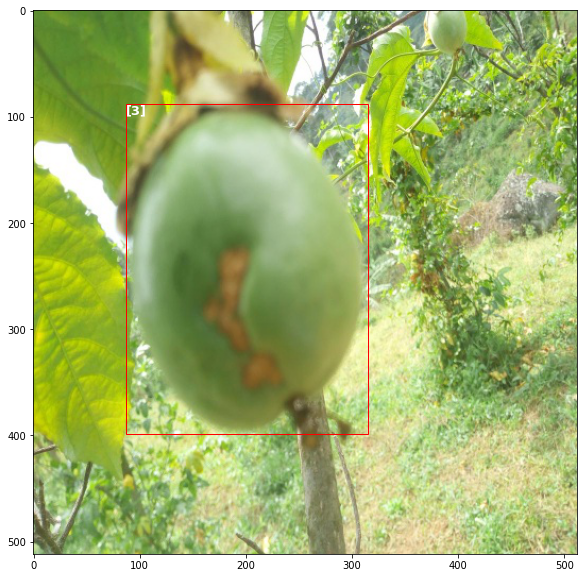

In [ ]:
name = df.Image_ID.unique()[0]
plot_image(name)

      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5
      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5


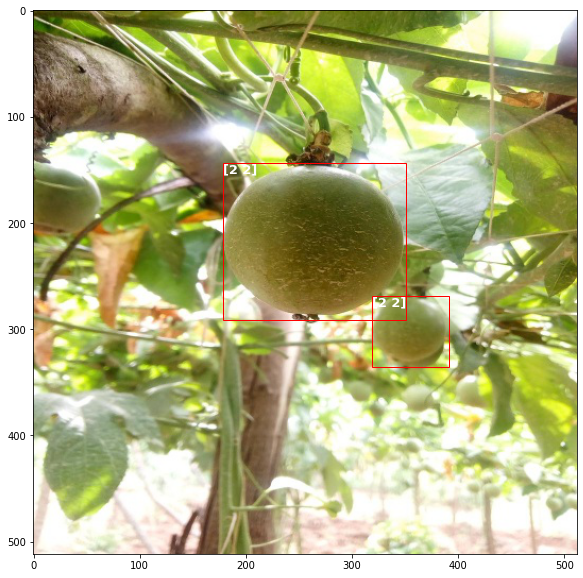

In [ ]:
name = df.Image_ID.unique()[700]
plot_image(name)

     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0
     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0


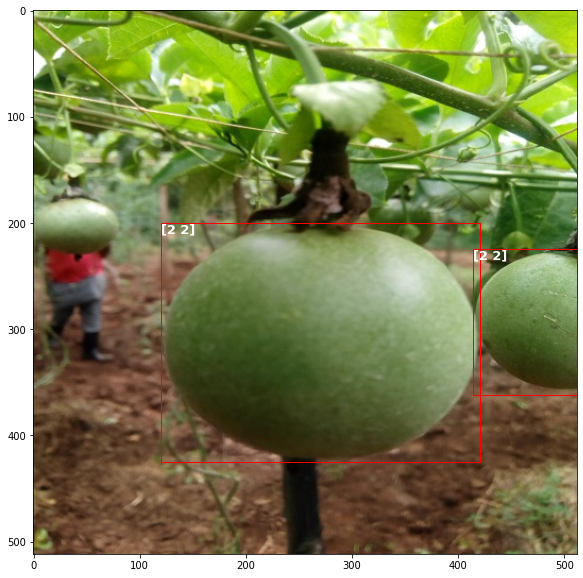

In [ ]:
name = df.Image_ID.unique()[67]
plot_image(name)

In [ ]:
from skimage import io

In [ ]:
class PassionFruit(object):
    def __init__(self, df, IMG_DIR, transf = None ): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique()
        self.transforms = transf
        
  
        self.classes = ["fruit_brownspot", "fruit_healthy", "fruit_woodiness"]
        # if self.classes[0] != "background":
        #     self.classes = ["background"] + self.classes
        # self.label_map = {c: i for i, c in enumerate(self.classes)}
        # self.lst = list(label_map.values())
        #self.label_map['background'] = 0
      
    def get_classes(self):
        return self.classes

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
     
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image =  io.imread(self.img_dir+image_id+".jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values -1
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(boxes.shape[0], dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

In [ ]:
class Test_PassionFruit(object):
    def __init__(self, df, IMG_DIR): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique()
        self.transforms = None
        
  
        self.classes = ["fruit_brownspot", "fruit_healthy", "fruit_woodiness"]
        # if self.classes[0] != "background":
        #     self.classes = ["background"] + self.classes
        # self.label_map = {c: i for i, c in enumerate(self.classes)}
        # self.lst = list(label_map.values())
        #self.label_map['background'] = 0
      
    def get_classes(self):
        return self.classes

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
     
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image =  io.imread(self.img_dir+image_id+".jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image
            }
        
            sample = self.transforms(**sample)
            image = sample['image']

        return image

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"
# import albumentations
# from albumentations.pytorch.transforms import ToTensorV2
# import albumentations as A
# !pip install torch
# !pip install torchvision
# !apt install -y albumentations 
# !pip install -qU albumentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        #A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        #A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# image_ids = df['Image_ID'].unique()
# valid_ids = image_ids[-665:]
# train_ids = image_ids[:-665]
# valid_df = df[df['Image_ID'].isin(valid_ids)]
# train_df = df[df['Image_ID'].isin(train_ids)]
# train_df.shape,valid_df.shape
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['class'], test_size=0.25, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2929, 8), (977, 8), (2929,), (977,))

In [ ]:
df = train_df.copy()

In [ ]:
get_train_transform()

Compose([
  Flip(always_apply=0.5, p=0.5),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0}, keypoint_params=None, additional_targets={})

In [ ]:
train_df

,Image_ID,class,xmin,ymin,xmax,ymax,width,height
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5,233.5,182.0
...,...,...,...,...,...,...,...,...
3901,ID_ZZAB1FH1,2,96.0,175.5,385.5,397.5,289.5,222.0
3902,ID_ZZAB1FH1,2,330.0,241.0,512.0,421.5,182.0,180.5
3903,ID_ZZJZ2CV6,2,358.0,234.0,492.5,341.0,134.5,107.0
3904,ID_ZZJZ2CV6,2,98.5,135.0,374.0,348.5,275.5,213.5


In [ ]:
train_dataset = PassionFruit(train_df, path, get_train_transform())


In [ ]:
test_dataset = PassionFruit(test_df, path2)

In [ ]:
zindi_test_data_loader = DataLoader(
  test_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  # collate_fn= collate_fn
)

In [ ]:
train_dataset

In [ ]:
image, target= train_dataset.__getitem__(0)
print(image.shape)
print(target['boxes'])
print(target['labels'])

torch.Size([3, 512, 512])
tensor([[197.0000, 113.5000, 425.0000, 424.5000]], dtype=torch.float64)
tensor([2])


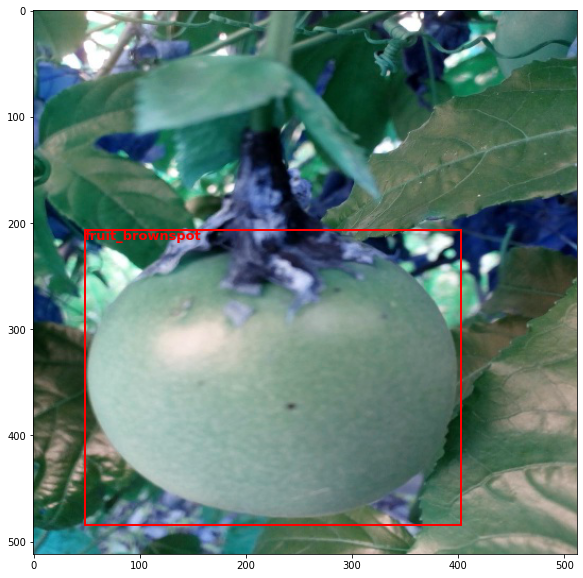

In [ ]:
img, tar = train_dataset[random.randint(0,1000)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"fruit_brownspot",  2:"fruit_healthy", 3:"fruit_woodiness"}
    l= classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

#### Plotting the bounding boxes using the dataframe

In [ ]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  test_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

In [ ]:
def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [ ]:
!git clone https://github.com/pytorch/vision.git
!cd vision && git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from engine import _get_iou_types
from engine import *

from utils import *
from coco_eval import *
from coco_utils import *
from transforms import *


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
    torch_dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=collate_fn)  
    # data_loader_test = torch.utils.data.DataLoader(
    #     torch_dataset_test, batch_size=1, shuffle=False, num_workers=2,
    #     collate_fn=collate_fn)
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    #device = torch.device("cpu")
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)
    # epoch = 1
    # train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)


In [ ]:
model = get_model(4)


In [ ]:

do_training(model, train_dataset, test_dataset, num_epochs=10)

Using device cpu
Epoch: [0]  [   0/1501]  eta: 12:39:33  lr: 0.000010  loss: 1.1579 (1.1579)  loss_classifier: 1.0753 (1.0753)  loss_box_reg: 0.0794 (0.0794)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 30.3623  data: 0.1692  max mem: 0
Epoch: [0]  [  10/1501]  eta: 12:02:35  lr: 0.000060  loss: 1.2013 (1.1970)  loss_classifier: 1.0531 (1.0153)  loss_box_reg: 0.1659 (0.1709)  loss_objectness: 0.0074 (0.0077)  loss_rpn_box_reg: 0.0026 (0.0030)  time: 29.0780  data: 0.0225  max mem: 0
Epoch: [0]  [  20/1501]  eta: 11:58:54  lr: 0.000110  loss: 0.9149 (0.9447)  loss_classifier: 0.6958 (0.7519)  loss_box_reg: 0.1659 (0.1825)  loss_objectness: 0.0048 (0.0075)  loss_rpn_box_reg: 0.0022 (0.0027)  time: 29.0633  data: 0.0077  max mem: 0
Epoch: [0]  [  30/1501]  eta: 11:52:43  lr: 0.000160  loss: 0.5371 (0.7541)  loss_classifier: 0.2714 (0.5694)  loss_box_reg: 0.1338 (0.1755)  loss_objectness: 0.0016 (0.0065)  loss_rpn_box_reg: 0.0021 (0.0027)  time: 29.0677  data

KeyboardInterrupt: ignored

In [ ]:
train_dataset.__getitem__(1)[0
                             ]

In [ ]:
# from engine import *
# data_loader_test = torch.utils.data.DataLoader(
#     train_dataset, batch_size=1, shuffle=False, num_workers=2,
#     collate_fn=collate_fn)
# # train on the GPU or on the CPU, if a GPU is not available
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# #device = torch.device("cpu")
# print("Using device %s" % device)

# # move model to the right device
# model.to(device)

# # construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)
# # and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=3,
#                                                 gamma=0.1)

# lr_scheduler.step()
# # evaluate on the test dataset
# evaluate(model, data_loader_test, torch.device('cuda'))

In [ ]:
torch.save(model.state_dict(), 'passion_fruit_model.pt')

from google.colab import files
files.download('passion_fruit_model.pt') 

In [ ]:
single_image= valid_data_loader.dataset[0]

pred = model(single_image.type('torch.FloatTensor'))

In [ ]:
type(single_image)

In [ ]:
single_image

In [ ]:
zindi_test_data_loader = DataLoader(
  test_dataset
)

In [ ]:
plt.show(zindi_test_data_loader.dataset[0])

In [ ]:
test_path = "/content/Test_Images"
for img in os.listdir(test_path):
  img = io.imread(os.path.join(test_path, img))
  print(img)
  break

In [ ]:
(img = io.imread("/content/Test_Images/ID_0082Y2NI.jpg")

plt.imshow(img)

In [ ]:
from PIL import Image
from torchvision import transforms
convert_tensor = transforms.ToTensor()

In [ ]:
hash = pd.DataFrame(columns = ['Image_ID','class','confidence',	'ymin',	'xmin',	'ymax',	'xmax'])

In [ ]:
classes_laudu = {1:"fruit_brownspot" , 2:"fruit_healthy",3:"fruit_woodiness"}

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_path = "/content/Test_Images"
model.eval().to(device)
i = 0
for img in os.listdir(test_path):
  image_id = img.rstrip('.jpg')
  
  try:
    img = Image.open(os.path.join(test_path, img)).convert('RGB')
  except:
    continue
  # img = io.imread(os.path.join(test_path, img)).astype('float')
  # img/=255.0
  with torch.no_grad():
      # img = torch.from_numpy(img)
      img = convert_tensor(img)
      prediction = model([img.to(device)]) #torch.from_numpy(x)
      
      if len(prediction[0]['boxes'])==0:
        boxes = [0,0,0,0]
      else:
        boxes = prediction[0]['boxes'][0]
      if len(prediction[0]['labels']) == 0:
        classs = ['fruit_brownspot']
      else:
        classs = prediction[0]['labels'][0]
        classs = classes_laudu[int(classs)]

      if len(prediction[0]['scores']) == 0:
        confidence = 0.0
      else:
        confidence = float(prediction[0]['scores'][0])
      row = [image_id, classs, confidence, float(boxes[0]), float(boxes[1]), float(boxes[2]), float(boxes[3])]
      hash.loc[len(hash),:] = row
     
  # print(hash)  
  # i+=1
  # break


In [ ]:
hash.to_csv('submission_2.csv')

In [ ]:
print("prdiction for 1 image", prediction)